![image](https://www.technotification.com/wp-content/uploads/2018/09/Renewable-Energy-Ideas-1200x600.jpg)
Image source: [technotification](https://www.technotification.com/2018/09/amazing-renewable-energy-ideas.html)

This notebook aims to predict a building's energy consumption over 2017 and 2018 using the data from 2016 in 4 different consumpiton categories (electricity, chilled water, steam, hot water) using ASHRAE data, which is our problem statement as well.

This is a supervised machine learning model, meaning based on the columns available in the datasets and data from 2016, we are going to train the model to predict an energy consumption of a building in each category. Since, consumption values are labeled as meter_reading and they are continuous, we are going to apply regression techniques to generate predictions on meter_reading.

It is a highly debated and popular competition in Kaggle currently, however my main motivation is to contribute to make energy-efficient buildings by estimating its energy consumption. It seemed like a good start to save our energy for future!

There will be 3 notebooks covering the complete machine learning building pipeline. 
* [Notebook 1](https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-1-detailed-eda) covered understanding, formating the data and detailed EDA. 
* [Notebook 2](https://www.kaggle.com/cereniyim/save-the-energy-for-the-future-2-fe-lightgbm) consists of the feature engineering, building the model and tuning its parameters.

This third and last notebook will focus on parts 6, 7 and 8 focusing on generating predictions, evaluating them and a summary about the whole project.

1) Understand, Cleand and Format Data

2) Exploratory Data Analysis

3) Feature Engineering & Selection

4) Compare Several Machine Learning Models

5) Perform Hyperparameter Tuning and Cross Validation

**6) Evaluate Model with Test Data**

**7) Interpret Model Results**

**8) Summary & Conclusions**

Machine Learning application and building is not a linear and one time process. Steps above enable me to follow a structured way for an end-to-end machine project flow and preparation for the each step ahead. All in all, steps might be modified or revisited according to findings. You can use the table of contents to navigate to each section. 👇

Enjoy reading !

# <a id = 'top'> Table of Contents </a>
  - <a href = '#1'> Quick Recap from Previous Notebook </a>
  - <a href = '#6'> 6. Evaluate Model with Test Data </a>
    - <a href = '#6-1'> 6.1. Load training data for re-creating model </a>
    - <a href = '#6-2'> 6.2. Build model </a>
    - <a href = '#6-3'> 6.3. Feature alignment between training and test set </a>
      - <a href = '#6-3-1'> 6.3.1. Load and merge dataframes </a>
      - <a href = '#6-3-2'> 6.3.2. Add features </a>
      - <a href = '#6-3-3'> 6.3.3. Drop not-used features </a>
      - <a href = '#6-3-4'> 6.3.4. Split test data for 2017 and 2018 </a>
      - <a href = '#6-3-5'> 6.3.5. Impute missing values </a>
      - <a href = '#6-3-6'> 6.3.6. Add dataframes back </a>
    - <a href = '#6-4'> 6.4. Make sure test data shape and check for missing values </a>
    - <a href = '#6-5'> 6.5. Generate predictions </a>
  - <a href = '#7'> 7. Interpret Model Results </a>
  - <a href = '#8'> 8. Submissions & Summary & Conclusions </a>

In [1]:
# for data manipulation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# pandas options
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('mode.use_inf_as_na', True)
pd.options.mode.chained_assignment = None

# for date manipulation
from datetime import datetime

# for visualization: matplotlib
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize
%matplotlib inline
# to display visuals in the notebook

# for visualization: seaborn
import seaborn as sns
sns.set_context(font_scale=2)

# for data preprocessing
from sklearn.preprocessing import LabelEncoder
from itertools import combinations
from sklearn.model_selection import KFold

# for building the model and calculate RMSE
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from math import sqrt

# to cleanup memory usage
import gc

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ashrae-energy-prediction/test.csv
/kaggle/input/ashrae-energy-prediction/building_metadata.csv
/kaggle/input/ashrae-energy-prediction/train.csv
/kaggle/input/ashrae-energy-prediction/weather_test.csv
/kaggle/input/ashrae-energy-prediction/sample_submission.csv
/kaggle/input/ashrae-energy-prediction/weather_train.csv
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/__notebook__.ipynb
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/__results__.html
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/__output__.json
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/X.csv
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/__resultx__.html
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/y.csv
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/custom.css
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/__results___files/__results___108_1.png
/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/__res

In [2]:
## Function to reduce the DF size and reduce test dataframe size
def reduce_memory_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))

# <a id = '1'> Quick Recap from Previous Notebook </a>
<a href = '#top'> Back to top </a>

In the previous notebook, we focused on feature engineering, building model and improving the evaluation metric (RMSE) further with cross validation and hyperparameter optimization.

With feature engineering, we extracted and transformed features from the existing columns, added features by combining weather variables. Afterwards, with a univariate feature selection method, looking at the pearson coefficients of the features to the log1p of the meter_reading, we determined on final 30 features.

For model selection, linear regression, k nearest neighbor regressor and light gradient boosting models are built. Light gbm delivered the best results. After applying the cross-validation results RMSE improved from 1.21 to 1.1, hyperparameter search did not help much in improving the results. 

**Here is a visual from how training and validation error improved in from one of the cross-validation folds of Light GBM:**
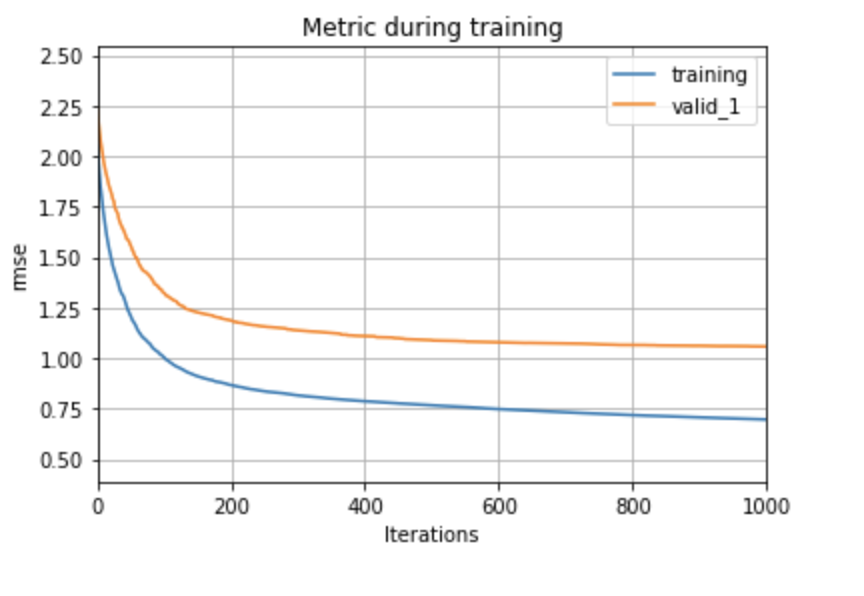

I will perform same steps performed in the feature engineering to align test set with the training set. With the cross validated model I will generate the predictions and evaluate them.

Finally, I will end the project with an overall summary.

# <a id = '6'> 6. Evaluate Model with Test Data </a>
<a href = '#top'> Back to top </a>

## <a id = '6-1'> 6.1. Load training data for re-creating model </a>
<a href = '#top'> Back to top </a>

In [3]:
# load training data created in the second notebook into dataframes
X = pd.read_csv("/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/X.csv")
y = pd.read_csv("/kaggle/input/save-the-energy-for-the-future-2-fe-lightgbm/y.csv", header=None)

# rename target as log_meter_reading
y.rename(columns = {0: "log_meter_reading"}, 
         inplace=True)

reduce_memory_usage(X)
reduce_memory_usage(y)

Mem. usage decreased to 1021.82 Mb (77.9% reduction)
Mem. usage decreased to 38.56 Mb (75.0% reduction)


## <a id = '6-2'> 6.2. Build model </a>
<a href = '#top'> Back to top </a>

In [4]:
# create categorical features
categorical_features = ['building_id', 'site_id', 'meter',
                        'primary_use', 'cloud_coverage', 'wind_compass_direction',
                        'day_of_week', 'hour','is_weekend', 'season']

# initial parameters of light gbm algorithm
initial_params = {"objective": "regression",
                  "boosting": "gbdt",
                  "num_leaves": 60,
                  "learning_rate": 0.05,
                  "feature_fraction": 0.85,
                  "reg_lambda": 2,
                  "metric": {'rmse'}
}

In [5]:
# cretae kfold object and empty model and evaluation lists
kf = KFold(n_splits=4, shuffle=False, random_state=42)

# save 4 model as a list
models = []

# dynamically split X and y with the k-fold split indexes
for train_index,valid_index in kf.split(X):
    X_train_kf = X.loc[train_index]
    y_train_kf = y.loc[train_index]
    
    X_valid_kf = X.loc[valid_index]
    y_valid_kf = y.loc[valid_index]
    
    d_train = lgb.Dataset(X_train_kf, 
                          label=y_train_kf,
                          categorical_feature=categorical_features, 
                          free_raw_data=False)
    
    d_valid = lgb.Dataset(X_valid_kf, 
                          label=y_valid_kf,
                          categorical_feature=categorical_features, 
                          free_raw_data=False)
    
    model = lgb.train(initial_params, 
                      train_set=d_train, 
                      num_boost_round=1000, 
                      valid_sets=[d_train, d_valid],
                      verbose_eval=100, 
                      early_stopping_rounds=500)
    
    models.append(model)
    
    del X_train_kf, y_train_kf, X_valid_kf, y_valid_kf, d_train, d_valid
    gc.collect()

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 1.01095	valid_1's rmse: 1.3467
[200]	training's rmse: 0.864974	valid_1's rmse: 1.20228
[300]	training's rmse: 0.811649	valid_1's rmse: 1.15564
[400]	training's rmse: 0.784314	valid_1's rmse: 1.13376
[500]	training's rmse: 0.762938	valid_1's rmse: 1.11489
[600]	training's rmse: 0.747246	valid_1's rmse: 1.10528
[700]	training's rmse: 0.731628	valid_1's rmse: 1.09707
[800]	training's rmse: 0.718427	valid_1's rmse: 1.0925
[900]	training's rmse: 0.707689	valid_1's rmse: 1.08867
[1000]	training's rmse: 0.698303	valid_1's rmse: 1.0834
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 0.698303	valid_1's rmse: 1.0834
Training until validation scores don't improve for 500 rounds
[100]	training's rmse: 0.980005	valid_1's rmse: 1.14631
[200]	training's rmse: 0.851308	valid_1's rmse: 1.08726
[300]	training's rmse: 0.797002	valid_1's rmse: 1.06677
[400]	training's rmse: 0.762474	valid_1's rmse:

In [6]:
del X
del y
gc.collect()

0

## <a id = '6-3'> 6.3. Feature alignment between training and test set </a>
<a href = '#top'> Back to top </a>

### <a id = '6-3-1'> 6.3.1. Load and merge dataframes </a>
<a href = '#top'> Back to top </a>

In [7]:
# load test  data
building = pd.read_csv("/kaggle/input/ashrae-energy-prediction/building_metadata.csv")
weather_test = pd.read_csv("/kaggle/input/ashrae-energy-prediction/weather_test.csv")
test = pd.read_csv("/kaggle/input/ashrae-energy-prediction/test.csv")

In [8]:
# merge dataframes on test dataframe
test = test.merge(building, on = "building_id", how = "left")
test = test.merge(weather_test, on = ["site_id", "timestamp"], how="left")

# convert timestamp column to date time data type column
test["timestamp"] = pd.to_datetime(test["timestamp"],
                                   format='%Y-%m-%d %H:%M:%S')

# delete the other ones to save space from the memory
del weather_test
del building
gc.collect()

0

In [9]:
reduce_memory_usage(test)

Mem. usage decreased to 2147.36 Mb (60.3% reduction)


### <a id = '6-3-2'> 6.3.2. Add features </a>
<a href = '#top'> Back to top </a>

In [10]:
# create functions
def convert_direction(series):
    if series <= 90:
        return 0
    # as norteast direction
    elif series <= 180:
        return 1
    # as southeast direction
    elif series <= 270:
        return 2
    # as southwest direction
    elif series <= 360:
        return 3
    # as northwest direction

def convert_season(month):
    if (month <= 2) | (month == 12):
        return 0
    # as winter
    elif month <= 5:
        return 1
    # as spring
    elif month <= 8:
        return 2
    # as summer
    elif month <= 11:
        return 3
    # as fall

In [11]:
# add wind_direction
test['wind_compass_direction'] = test.wind_direction.apply(convert_direction)
test.drop(columns=['wind_direction'], inplace=True)

# transform primary_use
le = LabelEncoder()
le_primary_use = le.fit_transform(test.primary_use)
test['primary_use'] = le_primary_use
del le, le_primary_use
gc.collect()

# add building age column
current_year = datetime.now().year
test['building_age'] = current_year - test['year_built']
test.drop(columns=['year_built'], inplace=True)

# add month, day of week, day of month, hour, season and year
test['month'] = test['timestamp'].dt.month.astype(np.int8)
test['day_of_week'] = test['timestamp'].dt.dayofweek.astype(np.int8)
test['day_of_month']= test['timestamp'].dt.day.astype(np.int8)
test['hour'] = test['timestamp'].dt.hour
test['is_weekend'] = test.day_of_week.apply(lambda x: 1 if x>=5 else 0)
test['season'] = test.month.apply(convert_season)
test["year"] = test["timestamp"].dt.year

# create list of weather variables
# create weather variables combinations
weather_variables = ["air_temperature", "cloud_coverage", "dew_temperature",
                     "precip_depth_1_hr", "sea_level_pressure", "wind_speed"]

for i, j in combinations(weather_variables, 2):
    test["mean" + i + "_" + j] = (test[i] + test[j]) / 2

### <a id = '6-3-3'> 6.3.3. Drop not-used features </a>
<a href = '#top'> Back to top </a>

In [12]:
#feature_set = ['building_age', 'le_primary_use', 'cloud_coverage',
#               'is_weekend','wind_speed', 'day_of_week',
#               'wind_compass_direction', 'sea_level_pressure', 'air_temperature',
#               'day_of_month', 'dew_temperature', 'hour', 
#               'month', 'meter', 'building_id', 
#               'site_id', 'floor_count', 'square_feet', 'year']

In [13]:
test.columns

Index(['row_id', 'building_id', 'meter', 'timestamp', 'site_id', 'primary_use',
       'square_feet', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_speed', 'wind_compass_direction', 'building_age', 'month',
       'day_of_week', 'day_of_month', 'hour', 'is_weekend', 'season', 'year',
       'meanair_temperature_cloud_coverage',
       'meanair_temperature_dew_temperature',
       'meanair_temperature_precip_depth_1_hr',
       'meanair_temperature_sea_level_pressure',
       'meanair_temperature_wind_speed', 'meancloud_coverage_dew_temperature',
       'meancloud_coverage_precip_depth_1_hr',
       'meancloud_coverage_sea_level_pressure',
       'meancloud_coverage_wind_speed',
       'meandew_temperature_precip_depth_1_hr',
       'meandew_temperature_sea_level_pressure',
       'meandew_temperature_wind_speed',
       'meanprecip_depth_1_hr_sea_level_pressure',
       'meanprecip_depth_1_hr_wind_s

In [14]:
test.drop(columns = ["row_id", 
                     "timestamp", 
                     "floor_count", 
                     "meanprecip_depth_1_hr_wind_speed", 
                     "meanair_temperature_cloud_coverage", 
                     "meandew_temperature_wind_speed", 
                     "meanair_temperature_dew_temperature"], 
          inplace=True)

In [15]:
print("Number of unique columns in the test dataset:", test.shape[1])

Number of unique columns in the test dataset: 31


With the memory usage concerns, I will split test dataset for 2017 and 2018 based on `year` column. If we ignore year column test dataset has 30 columns, aligning with the train datasets.

### <a id = '6-3-4'> 6.3.4. Split test data for 2017 and 2018 </a>
<a href = '#top'> Back to top </a>

In [16]:
# split test set based on year and 75 and 25 percent sequentially for imputing reasons
test_2017 = test[test['year'] == 2017]
test_2017_1 = test_2017[:int(3 * test_2017.shape[0] / 4)]
test_2017_2 = test_2017[int(3 * test_2017.shape[0] / 4):]

test_2018 = test[test['year'] == 2018]
test_2018_1 = test_2018[:int(3 * test_2018.shape[0] / 4)]
test_2018_2 = test_2018[int(3 * test_2018.shape[0] / 4):]

del test
del test_2017
del test_2018
gc.collect()

63

### <a id = '6-3-5'> 6.3.5. Impute missing values </a>
<a href = '#top'> Back to top </a>

In [17]:
# function to impute missing values with median values of the training set
def my_median_imputer(df_train, df_valid):
    for col in df_train.columns:
        col_median = df_train[col].median()
        df_train.fillna(col_median, inplace=True)
        df_valid.fillna(col_median, inplace=True)

In [18]:
my_median_imputer(test_2017_1, test_2017_2)
my_median_imputer(test_2018_1, test_2018_2)

### <a id = '6-3-6'> 6.3.6. Add dataframes back </a>
<a href = '#top'> Back to top </a>

In [19]:
# add dataframes back
X_test_2017 = pd.concat([test_2017_1,
                         test_2017_2])

In [20]:
X_test_2018 = pd.concat([test_2018_1,
                         test_2018_2])

In [21]:
reduce_memory_usage(X_test_2017)
reduce_memory_usage(X_test_2018)

del test_2017_1
del test_2017_2
del test_2018_1
del test_2018_2
gc.collect()

Mem. usage decreased to 1252.63 Mb (40.0% reduction)
Mem. usage decreased to 1252.63 Mb (40.0% reduction)


0

In [22]:
# drop year column since it is not a feature
X_test_2017.drop(columns=["year"], 
                 inplace=True)

X_test_2018.drop(columns=["year"], 
                 inplace=True)

## <a id = '6-4'> 6.4. Make sure test data shape and check for missing values </a>
<a href = '#top'> Back to top </a>

In [23]:
print('2017 Test Data Shape:', X_test_2017.shape)

2017 Test Data Shape: (20848800, 30)


In [24]:
print('2018 Test Data Shape:', X_test_2018.shape)

2018 Test Data Shape: (20848800, 30)


In [25]:
X_test_2017.isna().sum()

building_id                                 0
meter                                       0
site_id                                     0
primary_use                                 0
square_feet                                 0
air_temperature                             0
cloud_coverage                              0
dew_temperature                             0
precip_depth_1_hr                           0
sea_level_pressure                          0
wind_speed                                  0
wind_compass_direction                      0
building_age                                0
month                                       0
day_of_week                                 0
day_of_month                                0
hour                                        0
is_weekend                                  0
season                                      0
meanair_temperature_precip_depth_1_hr       0
meanair_temperature_sea_level_pressure      0
meanair_temperature_wind_speed    

In [26]:
X_test_2018.isna().sum()

building_id                                 0
meter                                       0
site_id                                     0
primary_use                                 0
square_feet                                 0
air_temperature                             0
cloud_coverage                              0
dew_temperature                             0
precip_depth_1_hr                           0
sea_level_pressure                          0
wind_speed                                  0
wind_compass_direction                      0
building_age                                0
month                                       0
day_of_week                                 0
day_of_month                                0
hour                                        0
is_weekend                                  0
season                                      0
meanair_temperature_precip_depth_1_hr       0
meanair_temperature_sea_level_pressure      0
meanair_temperature_wind_speed    

## <a id = '6-5'> 6.5. Generate predictions </a>
<a href = '#top'> Back to top </a>

I tried to generate the predictions with the as-is X_test however, I ran into the memory errors:
> Unable to allocate array with shape (41498571, 18) and data type float64)

So I am going to convert some float columns to int data types to occupy less space in the memory.

In [27]:
X_test_2017.memory_usage()

Index                                       166790400
building_id                                  41697600
meter                                        20848800
site_id                                      20848800
primary_use                                  20848800
square_feet                                  83395200
air_temperature                              41697600
cloud_coverage                               41697600
dew_temperature                              41697600
precip_depth_1_hr                            41697600
sea_level_pressure                           41697600
wind_speed                                   41697600
wind_compass_direction                       41697600
building_age                                 41697600
month                                        20848800
day_of_week                                  20848800
day_of_month                                 20848800
hour                                         20848800
is_weekend                  

In [28]:
X_test_2018.memory_usage()

Index                                       166790400
building_id                                  41697600
meter                                        20848800
site_id                                      20848800
primary_use                                  20848800
square_feet                                  83395200
air_temperature                              41697600
cloud_coverage                               41697600
dew_temperature                              41697600
precip_depth_1_hr                            41697600
sea_level_pressure                           41697600
wind_speed                                   41697600
wind_compass_direction                       41697600
building_age                                 41697600
month                                        20848800
day_of_week                                  20848800
day_of_month                                 20848800
hour                                         20848800
is_weekend                  

In [29]:
X_test_2017.dtypes

building_id                                   int16
meter                                          int8
site_id                                        int8
primary_use                                    int8
square_feet                                   int32
air_temperature                             float16
cloud_coverage                              float16
dew_temperature                             float16
precip_depth_1_hr                           float16
sea_level_pressure                          float16
wind_speed                                  float16
wind_compass_direction                      float16
building_age                                float16
month                                          int8
day_of_week                                    int8
day_of_month                                   int8
hour                                           int8
is_weekend                                     int8
season                                         int8
meanair_temp

In [30]:
# features that datatypes to be converted
int_features = ['building_age', 'primary_use', 'cloud_coverage', 
                'is_weekend',  'wind_compass_direction']

for feature in int_features:
    X_test_2017[feature] = X_test_2017[feature].astype('int8')
    X_test_2018[feature] = X_test_2018[feature].astype('int8')

In [31]:
X_test_2017.memory_usage()

Index                                       166790400
building_id                                  41697600
meter                                        20848800
site_id                                      20848800
primary_use                                  20848800
square_feet                                  83395200
air_temperature                              41697600
cloud_coverage                               20848800
dew_temperature                              41697600
precip_depth_1_hr                            41697600
sea_level_pressure                           41697600
wind_speed                                   41697600
wind_compass_direction                       20848800
building_age                                 20848800
month                                        20848800
day_of_week                                  20848800
day_of_month                                 20848800
hour                                         20848800
is_weekend                  

In [32]:
gc.collect()

0

If you remember, we took the np.log1p (natural logarithm of meter reading+1) of the meter reading values and trained our model with those values. So, our model learned to predict np.log1p values. 

To align the predictions back to the meter reading values, I am going to use the inverse function of log1p, np.expm1 and generate predictions for 2017 and 2018 seperately due to high memory usage.

np.expm1 function calculates the  exp(x) - 1 for all elements in the array.

Looking at the training and validation errors of this notebook and previous notebook I expect to see RMSE between 1.2 and 2.5.

In [33]:
predictions_2017 = []

for model in models:
    if  predictions_2017 == []:
        predictions_2017 = (np
                            .expm1(model
                                   .predict(X_test_2017, 
                                            num_iteration=model.best_iteration)) / len(models))
    else:
        predictions_2017 += (np
                             .expm1(model
                                    .predict(X_test_2017,
                                             num_iteration=model.best_iteration)) / len(models))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


In [34]:
del X_test_2017
gc.collect()

16

In [35]:
predictions_2018 = []

for model in models:
    if  predictions_2018 == []:
        predictions_2018 = (np
                            .expm1(model
                                   .predict(X_test_2018, 
                                            num_iteration=model.best_iteration)) / len(models))
    else:
        predictions_2018 += (np
                             .expm1(model
                                    .predict(X_test_2018, 
                                             num_iteration=model.best_iteration)) / len(models))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.


# <a id = '7'> 7. Interpret Model Results </a>
<a href = '#top'> Back to top </a>

In the feature engineering part, I selected features based on its pearson coefficients to the log_meter_reading values.  Since final results are generated, I will revisit this picture and observe features with the highest contribution to the model predictions. `plot_importances`  attribute will be used for this, visualizing each of the four model's feature importance individually.

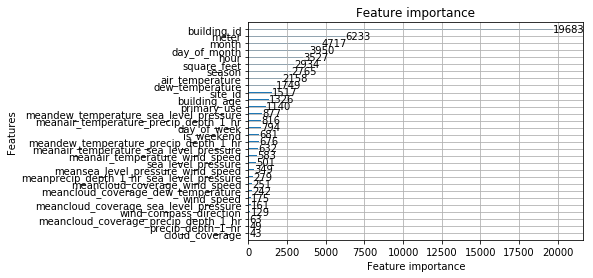

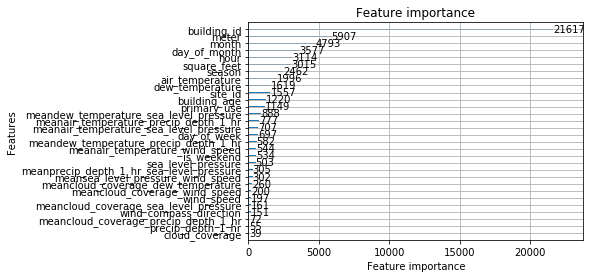

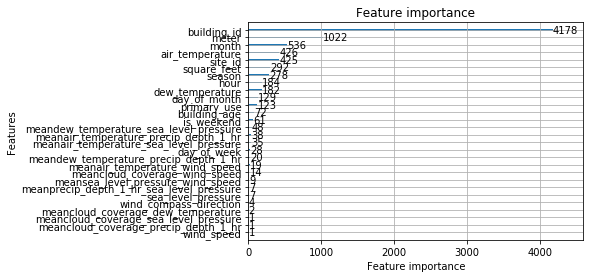

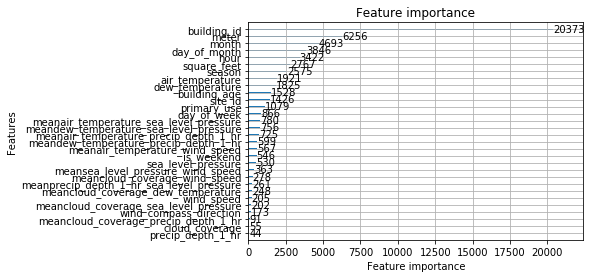

In [36]:
for model in models:
    lgb.plot_importance(model)
    plt.show()

**In all of the 4 models built, top 15 features for determining the meter reading values:**
* building_id
* meter
* month
* day of month
* square_feet
* season
* air temperature
* dew temperature
* building age
* site id
* primary use
* day of week
* mean dew tempereature and sea level pressure
* mean air temperature precip depth 1 hr
* day of week

# <a id = '8'> 8. Submissions & Summary & Conclusions  </a>
<a href = '#top'> Back to top </a>

Thank you for sticking with me until the very end! 😍

In this notebook, we covered:

6. Evaluate model with test data
7. Interpret model results
8. Submissions & summary & conclusions

Before summarizing the project I will submit predicitons. As I predicted 2017 and 2018 results seperately, I am going to merge them now into one dataframe.

In [37]:
# to fetch row_ids
sample_submission = pd.read_csv("/kaggle/input/ashrae-energy-prediction/sample_submission.csv")
row_ids = sample_submission.row_id

del sample_submission
gc.collect()

24437

In [38]:
# make sure of the shape of predictions
predictions_2017.shape

(20848800,)

In [39]:
predictions_2018.shape

(20848800,)

In [40]:
# split row_id's with the indexes of 2017 and 2018 predictions
row_ids_2017 = row_ids[:predictions_2017.shape[0]]
row_ids_2018 = row_ids[predictions_2018.shape[0]:]

In [41]:
submission_2017 = pd.DataFrame({"row_id": row_ids_2017, 
                                "meter_reading": np.clip(predictions_2017, 0, a_max=None)})

submission_2018 = pd.DataFrame({"row_id": row_ids_2018, 
                                "meter_reading": np.clip(predictions_2018, 0, a_max=None)})

In [42]:
submission = pd.concat([submission_2017,
                        submission_2018])

del submission_2017, submission_2018
gc.collect()

0

In [43]:
submission

,row_id,meter_reading
0,0,18.762
1,1,18.762
2,2,18.762
3,3,19.558
4,4,19.275
...,...,...
41697595,41697595,8.261
41697596,41697596,8.271
41697597,41697597,8.261
41697598,41697598,8.312


In [44]:
submission.to_csv("submission.csv", index=False)

In [45]:
del models
gc.collect()

5



We've come to an end in this long and comprehensive project, the highlights from the 3 notebooks and the machine learning workflow are: 

* Exploratory data analysis
* Feature engineering & selection
* Building an efficient model with model selection, tuning and cross-validation

First I understand analyzed what affects most a building's energy consumption in electricity, chilled water, steam and hot water. The area, purpose and age are the most important factors for a building to determine its energy consumption. The air temperature, humidity, sea level pressure and how cloudy the sky is at the current time are the most important weather factors for building's energy consumption.

Feature engineering showed its importance: with the newly generated features as part of this project had also high impact in determining the meter_reading values.

I moved forward with the light gbm model which seems as efficient solution when dealing with 20 or 40 million rows after exploring some other notebooks in this competition. Based on the 30 features selected and 1 year time-series data available (nearly 20 million rows) I predicted the next 2 years electricity, chilled water, hot water and steam consumption of each building (nearly 40 million rows). Even though I did not climb high in the competition ladder I learned a lot on the way which is more important for me.

During this project, I find a chance to explore new libraries such as pandas profiling, hyperopt and light gbm and learned to deal with large dataset as well as the RAM. Most importantly, I applied the machine learning workflow to a supervised regression problem for the first time, introduced by Will Koehrsen [in this article](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420).

Thank you everyone for reading, upvoting and commenting on my kernels. I hope that I contributed to make energy-efficient buildings with this project and inspire other people to join this cause with me. 

![image](https://i.pinimg.com/736x/7c/6e/1b/7c6e1b412a365376894828a348955372.jpg)
Image source: [pinterest](https://www.pinterest.com/pin/576179346069675606/) 